<a href="https://colab.research.google.com/github/EmmanuelABonsu/CE888/blob/main/src/project/feature_extraction_with_xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Convolution2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from keras import models, layers, optimizers 
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from tensorflow.keras.applications import EfficientNetB7, Xception

In [ ]:
# Defining file paths. Model data is stored in Kaggle
train_path = "../input/fire-detection-data/Training/Training"
test_path = "../input/fire-detection-data/Test/Test"
img_dimension = (254, 254)

## Data Inspection and Pre-processing

In [ ]:
# Initializing data generator to visualize images
train_image_gen_visual = ImageDataGenerator(rescale=1./255)                                 
test_image_gen_visual = ImageDataGenerator(rescale=1./255)
preprocessing_train_generator = train_image_gen_visual.flow_from_directory(train_path, 
                                                   target_size = img_dimension, 
                                                   batch_size = 1,
                                                   class_mode = 'binary')
preprocessing_test_generator = test_image_gen_visual.flow_from_directory(test_path, 
                                                   target_size = img_dimension, 
                                                   batch_size = 1,
                                                   class_mode = 'binary')

Found 45383 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [ ]:
def show_sample_images(generator, image_title):
  fig, axs = plt.subplots(nrows=1, ncols=7, figsize=(25,4))
  for i, ax in enumerate(axs.flatten()):
      img, label = generator.next()
      plt.sca(ax)
      plt.imshow(img[0])
      plt.title('Image: {}'.format(i+1))
  plt.suptitle(image_title)
  plt.show()

In [ ]:
def plot_distribution_of_data(generator, image_tile):
  selectedClasses = list(generator.class_indices.keys())
  plot_dict = {}
  for cls in range(len (generator.class_indices)):  
    plot_dict[selectedClasses[cls]] = list(generator.classes).count(cls)
  plt.bar(range(len(plot_dict)), list(plot_dict.values()), align='center')
  plt.xticks(range(len(plot_dict)), list(plot_dict.keys()))
  plt.ylabel("Count")
  plt.title("Distribution of " + image_tile + " Data")

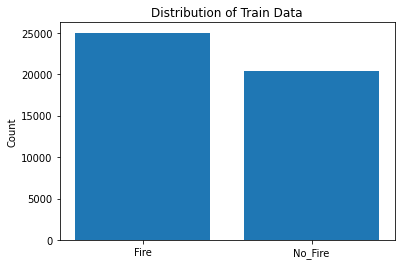

In [ ]:
plot_distribution_of_data(preprocessing_train_generator, "Train")

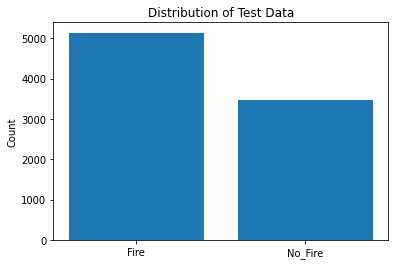

In [ ]:
plot_distribution_of_data(preprocessing_test_generator, "Test")

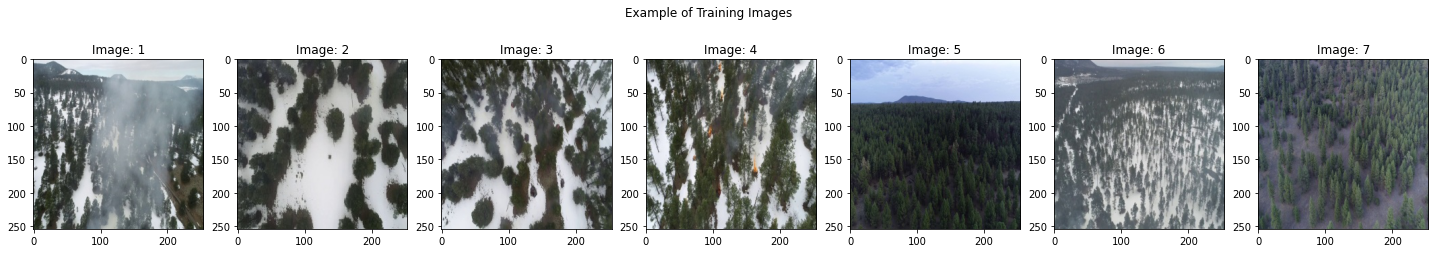

In [ ]:
# Displaying example images from train dataset 
show_sample_images(preprocessing_train_generator, "Example of Training Images")

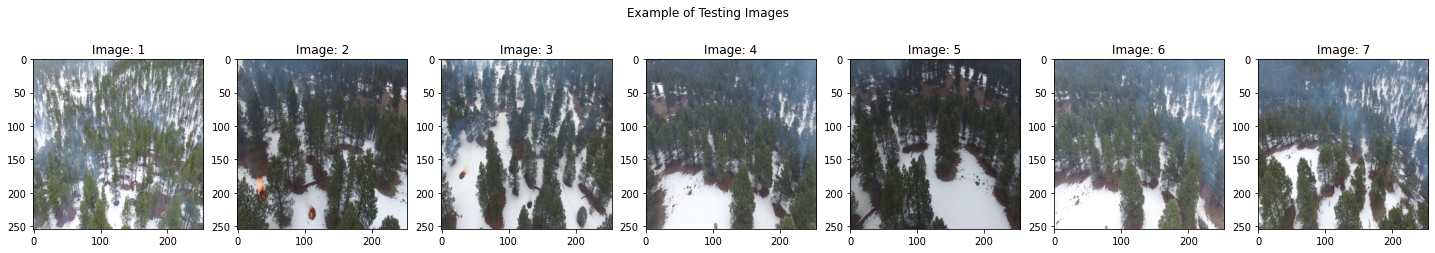

In [ ]:
# Displaying example images from test dataset
show_sample_images(preprocessing_test_generator, "Example of Testing Images")

In [ ]:
# Parameter for data generator
batch_size = 64
image_size = 224

In [ ]:
# Defining Training and Validation data sets
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    vertical_flip=True,            
    horizontal_flip=True,
    validation_split=0.20) # 80-20 split

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True,
    color_mode='rgb', 
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    train_path, # same directory as training data
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=True,
    color_mode='rgb', 
    class_mode='binary',
    subset='validation') # set as validation data

Found 36307 images belonging to 2 classes.
Found 9076 images belonging to 2 classes.


In [ ]:
def check_if_layers_are_frozen(model):
    for index, layer in enumerate(model.layers):
        print(index, layer.name, layer.trainable)

## Model Definition

In [ ]:
# Defining Pre-trained model
pre_trained_model = Xception(
        weights='imagenet',
        include_top = False,
        input_shape=(254, 254, 3)
    )
pre_trained_model.trainable = False 

pre_trained_model.summary()


Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 254, 254, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 126, 126, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 126, 126, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 126, 126, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [ ]:
# Defining Custom Connected Layer
input_layer = Input(shape=(254,254,3))
x = pre_trained_model(input_layer,training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
output_layer = Dense(1)(x)
model = Model(input_layer,output_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 254, 254, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2049      
Total params: 20,863,529
Trainable params: 2,049
Non-trainable params: 20,861,480
_________________________________________________________________


In [ ]:
# Inspect if layers of pre-trained model are not trainable 
check_if_layers_are_frozen(pre_trained_model)


0 input_4 False
1 block1_conv1 False
2 block1_conv1_bn False
3 block1_conv1_act False
4 block1_conv2 False
5 block1_conv2_bn False
6 block1_conv2_act False
7 block2_sepconv1 False
8 block2_sepconv1_bn False
9 block2_sepconv2_act False
10 block2_sepconv2 False
11 block2_sepconv2_bn False
12 conv2d_4 False
13 block2_pool False
14 batch_normalization_4 False
15 add_12 False
16 block3_sepconv1_act False
17 block3_sepconv1 False
18 block3_sepconv1_bn False
19 block3_sepconv2_act False
20 block3_sepconv2 False
21 block3_sepconv2_bn False
22 conv2d_5 False
23 block3_pool False
24 batch_normalization_5 False
25 add_13 False
26 block4_sepconv1_act False
27 block4_sepconv1 False
28 block4_sepconv1_bn False
29 block4_sepconv2_act False
30 block4_sepconv2 False
31 block4_sepconv2_bn False
32 conv2d_6 False
33 block4_pool False
34 batch_normalization_6 False
35 add_14 False
36 block5_sepconv1_act False
37 block5_sepconv1 False
38 block5_sepconv1_bn False
39 block5_sepconv2_act False
40 block5_sepco

In [ ]:
# Compile model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['acc']
              )

## Model Training - Initial Training

In [ ]:
# Defining Early Stopping Criteria, Model CHeckpoint, Learning Rate and Training Logs

model_check_point = ModelCheckpoint(filepath=" weights.{epoch:02d}-{val_loss:.2f}.h5",
                                                       mode="min",
                                                       monitor="val_loss",
                                                       verbose=1,
                                                       save_best_only=True,
                                                       save_weights_only=False)
reduce_lr_on_plateau = ReduceLROnPlateau(monitor="val_loss",factor=0.2,verbose=1,
                                                            mode="min",
                                                            patience=8,
                                                            min_delta=1e-4)
early_stopping = EarlyStopping(monitor="val_loss",min_delta=1e-5,verbose=1,
                                                  mode="min",
                                                  restore_best_weights=True,
                                                  patience=8)
tensor_board = TensorBoard(log_dir="logs")

# Defining custom call backs
custom_callbacks = [model_check_point, reduce_lr_on_plateau, early_stopping, tensor_board]

In [ ]:
# Begin model training 
history = model.fit(train_generator, 
                    epochs=20, 
                    validation_data=validation_generator,
                    workers=8,
                    steps_per_epoch=train_generator.samples  // batch_size,
                    validation_steps = validation_generator.samples // batch_size,
                    callbacks=custom_callbacks,
                    verbose=1)


Epoch 1/20
 12/567 [..............................] - ETA: 4:58 - loss: 3.7646 - acc: 0.4682

KeyboardInterrupt: 

In [ ]:
# Save Model for fine tuning
model.save('trained_xception_model.h5')

In [ ]:
# Plotting training and validation accuracy

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
# Plotting training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

In [ ]:
# Initializing test data pipeline

test_path = "../input/fire-detection-data/Test/Test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(254, 254),
        shuffle = False,
        class_mode='binary',
        batch_size=32)

In [ ]:
# Evaluating Trained Model
model.evaluate(test_generator)

## Mode Fine Tuning

In [ ]:
# Unfreezing Convolution Blocks
pre_trained_model.trainable = False 

In [ ]:
# Re-compiling model with lower learning accuracy 
model.compile(optimizer=keras.optimizers.Adam(1e-5),  # using low learning rate
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
# Begin fine tuning 
history = model.fit(train_generator, 
                    epochs=10, 
                    validation_data=validation_generator,
                    workers=8,
                    steps_per_epoch=train_generator.samples  // batch_size,
                    validation_steps = validation_generator.samples // batch_size,
                    callbacks=custom_callbacks,
                    verbose=1)

In [ ]:
# Inspect if layers of pre-trained model are trainable 
check_if_layers_are_frozen(pre_trained_model)

In [ ]:
# Evaluating Fine Tuned Model
model.evaluate(test_generator)

In [ ]:
# Saving Model 
model.save('fine_tuned_xception_model.h5')